In [1]:
import explogreg
import torch
from pyro.infer import MCMC, NUTS
import pyro.optim as optim

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/lineagt-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
L = 3
T = 5 # 6  # Number of time points
x = torch.tensor([0, 56,84,112,168,280]).unsqueeze(1)  # Time variable
y = torch.tensor([[0, 138, 188, 565, 572, 539], [0, 238, 548, 793, 649, 629], [0, 28, 128, 283, 405, 486]]).T  # Simulated binary outcomes (logistic regression)

In [3]:
obj = explogreg.Regression(x, y)
posterior_samples_log = obj.train_mcmc(regr="log", warmup_steps=1, num_samples=50, num_chains=2)

Sample [2]: 100%|██████████| 51/51 [00:02, 17.76it/s, step size=3.12e-02, acc. prob=0.015]


In [4]:
obj.mcmc

In [5]:
# Get posterior samples
for k, v in posterior_samples_log.items():
    print(k)
    print(v.shape)

carr_capac
(100, 3)
fitness
(100, 3)
init_time
(100, 3)
sigma
(100, 6, 3)


In [6]:
obj.mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
carr_capac[0]    877.52    201.55    681.38    676.10   1078.80       nan     80.14
carr_capac[1]   1154.56     97.44   1068.28   1049.77   1251.66       nan     41.80
carr_capac[2]    454.08     46.46    408.74    407.83    502.17       nan     49.23
   fitness[0]      0.23      0.18      0.12      0.05      0.39       nan      3.71
   fitness[1]      0.04      0.06      0.04      0.02      0.06       nan      1.02
   fitness[2]      1.73      1.72      0.15      0.01      3.45       nan     46.79
 init_time[0]     39.78     10.35     29.99     29.09     50.15       nan     38.20
 init_time[1]     35.95     16.35     20.26     19.31     52.26       nan     89.65
 init_time[2]     31.41     23.21      8.46      8.17     54.56       nan    129.20
   sigma[0,0]      0.17      0.04      0.16      0.14      0.22       nan      8.24
   sigma[0,1]      0.89      0.34      0.57      0.57      1.31       nan  

/Users/elenab/Library/r-miniconda-arm64/envs/lineagt-env/lib/python3.8/site-packages/pyro/infer/mcmc/util.py:498: UserWarning: Traceback (most recent call last):
  File "/Users/elenab/Library/r-miniconda-arm64/envs/lineagt-env/lib/python3.8/site-packages/pyro/infer/mcmc/util.py", line 496, in wrapped
    val = fn(sample, *args, **kwargs)
  File "/Users/elenab/Library/r-miniconda-arm64/envs/lineagt-env/lib/python3.8/site-packages/pyro/ops/stats.py", line 189, in effective_sample_size
    gamma_k_c = autocovariance(input, dim=0)  # N x C x sample_shape
  File "/Users/elenab/Library/r-miniconda-arm64/envs/lineagt-env/lib/python3.8/site-packages/pyro/ops/stats.py", line 137, in autocovariance
    return autocorrelation(input, dim) * input.var(dim, unbiased=False, keepdim=True)
  File "/Users/elenab/Library/r-miniconda-arm64/envs/lineagt-env/lib/python3.8/site-packages/pyro/ops/stats.py", line 97, in autocorrelation
    raise NotImplementedError(
NotImplementedError: For CPU tensor, this me

In [7]:
obj.get_learned_params()

{'carr_capac': array([ 877.5165 , 1154.5615 ,  454.07727], dtype=float32),
 'fitness': array([0.23098126, 0.03577183, 1.7335985 ], dtype=float32),
 'init_time': array([39.77603 , 35.95169 , 31.414322], dtype=float32),
 'sigma': array([[0.17239834, 0.89194834, 2.5050144 ],
        [1.7665707 , 3.04645   , 1.401306  ],
        [2.356453  , 2.9081573 , 3.8081367 ],
        [0.80735135, 3.3000696 , 2.3798673 ],
        [0.8883112 , 0.2529179 , 1.3681662 ],
        [1.9887592 , 3.7478476 , 2.9766395 ]], dtype=float32),
 'parent_rate': None}

In [8]:
obj.compute_log_likelihood()

array([[-3.3601236e-02, -9.6417151e-02, -2.0500633e-01],
       [-2.8373461e+00, -5.1120772e+00, -2.1907616e+02],
       [-2.2550240e+01, -8.9787884e+00, -3.7680463e+02],
       [-2.4010324e+01, -9.3860683e+00, -3.0742023e+02],
       [-5.0493046e+01, -5.3001566e+00, -1.5114648e+02],
       [-1.1582544e+02, -1.1265973e+01,  1.8021513e+02]], dtype=float32)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

n_iters = posterior_samples_log["fitness"].shape[0]

# Generate new x values (e.g., test points for prediction)
x_test = torch.linspace(0, 300, 50)
post_fitness = posterior_samples_log["fitness"][:, None]
post_carr = posterior_samples_log["carr_capac"][:, None]

args = - post_fitness * x_test.unsqueeze(1).numpy()
y_preds = post_carr / ( 1 + (post_carr - 1) * np.exp(args) )

print("x_test: {}".format(x_test.shape))
print("post_fitness: {}".format(post_fitness.shape))
print("post_carr: {}".format(post_carr.shape))
print("args: {}".format(args.shape))
print("y_preds: {}".format(y_preds.shape))

x_test: torch.Size([50])
post_fitness: (100, 1, 3)
post_carr: (100, 1, 3)
args: (100, 50, 3)
y_preds: (100, 50, 3)


<ipython-input-20-df7cb992edeb>:12: RuntimeWarning: overflow encountered in exp
  y_preds = post_carr / ( 1 + (post_carr - 1) * np.exp(args) )
<ipython-input-20-df7cb992edeb>:12: RuntimeWarning: overflow encountered in multiply
  y_preds = post_carr / ( 1 + (post_carr - 1) * np.exp(args) )


In [22]:
# Compute predictions for each posterior sample
y_mean = y_preds.mean(axis=0)  # Mean prediction
y_lower = np.quantile(y_preds, 0.05, axis=0)  # 2.5% quantile (
y_upper = np.quantile(y_preds, 0.95, axis=0)  # 97.5% quantile (upper bound)

print("y_mean: {}".format(y_mean.shape))
print("y_lower: {}".format(y_lower.shape))
print("y_upper: {}".format(y_upper.shape))

y_mean: (50, 3)
y_lower: (50, 3)
y_upper: (50, 3)


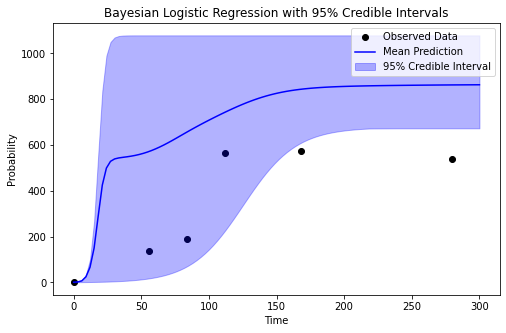

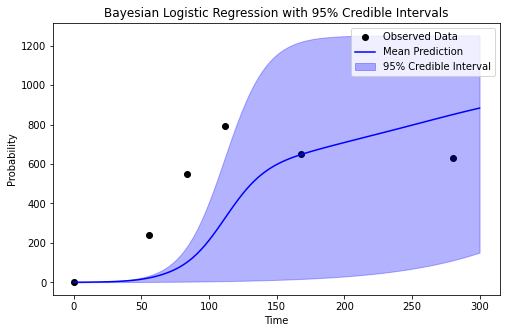

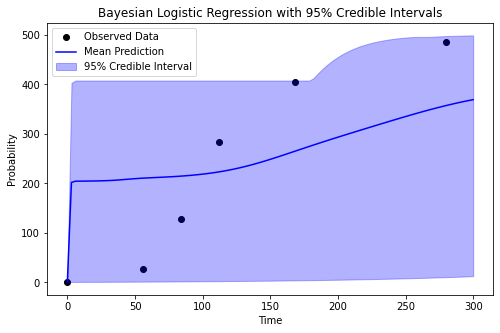

In [11]:
# Plot results

for i in range(L):
    plt.figure(figsize=(8, 5))
    plt.scatter(x.squeeze(), y[:,i], color="black", label="Observed Data")  # Scatter plot of actual data
    plt.plot(x_test, y_mean[:,i], label="Mean Prediction", color="blue")
    plt.fill_between(x_test, y_lower[:,i], y_upper[:,i], color="blue", alpha=0.3, label="95% Credible Interval")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Bayesian Logistic Regression with 95% Credible Intervals")
    plt.show()

In [12]:
posterior_samples_log["fitness"].shape

(100, 3)

In [13]:
pars = obj.get_learned_params()
pars

{'carr_capac': array([ 877.5165 , 1154.5615 ,  454.07727], dtype=float32),
 'fitness': array([0.23098126, 0.03577183, 1.7335985 ], dtype=float32),
 'init_time': array([39.77603 , 35.95169 , 31.414322], dtype=float32),
 'sigma': array([[0.17239834, 0.89194834, 2.5050144 ],
        [1.7665707 , 3.04645   , 1.401306  ],
        [2.356453  , 2.9081573 , 3.8081367 ],
        [0.80735135, 3.3000696 , 2.3798673 ],
        [0.8883112 , 0.2529179 , 1.3681662 ],
        [1.9887592 , 3.7478476 , 2.9766395 ]], dtype=float32),
 'parent_rate': None}

In [14]:
for k, v in posterior_samples_log.items():
    print(k)
    print(v.shape)

carr_capac
(100, 3)
fitness
(100, 3)
init_time
(100, 3)
sigma
(100, 6, 3)


In [15]:
posterior_samples_log

{'carr_capac': array([[1059.713  , 1245.4672 ,  408.74307],
        [1059.713  , 1245.4672 ,  408.74307],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  , 1251.656  ,  407.8334 ],
        [1078.797  ,